In [1]:
import os, sys
os.sys.path.append('..')
# from recommender.utils import mongodbutils as mdb
from recommender.utils.ItemMetadata import ExplicitDataFromCSV
from recommender.utils.eval_utils import compute_auc, compute_ap
# from recommender.recommender.recommenderMF import RecommenderMF
from recommender.recommender.recommenderALS import RecommenderALS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_folder = 'D:\\PycharmProjects\\recommender\\data\\ml-latest-small'
ratings_csv = os.path.join(data_folder, 'ratings_sanitized.csv')
user_map_csv = os.path.join(data_folder, 'user_map.csv')
item_map_csv = os.path.join(data_folder, 'item_map.csv')
md_csv = os.path.join(data_folder, 'metadata.csv')
stats_csv = os.path.join(data_folder, 'stats.csv')
df_train = os.path.join(data_folder, 'ratings_train.csv')
df_test = os.path.join(data_folder, 'ratings_test.csv')
d = ExplicitDataFromCSV(True,
                        ratings_csv=ratings_csv,
                        user_map_csv=user_map_csv,
                        item_map_csv=item_map_csv,
                        md_csv=md_csv,
                        stats_csv=stats_csv,
                        ratings_train_csv=df_train,
                        ratings_test_csv=df_test
                        )

In [3]:
# ratings_csv = 'D:/PycharmProjects/recommender/data/ml-latest-small/ratings.csv'
# movies_csv = 'D:/PycharmProjects/recommender/data/ml-latest-small/movies.csv'
# d = ExplicitDataFromCSV(False,
#                         ratings_csv=ratings_csv, r_item_col='movieId', r_user_col='userId',
#                         r_rating_col='rating',
#                         metadata_csv=movies_csv, m_item_col='movieId')
# d.save('D:\\PycharmProjects\\recommender\\data\\ml-latest-small')

In [4]:
# model_path = 'D:/PycharmProjects/recommender/recommender/models/model/07201914185949/'
# rmf = RecommenderMF(mode='predict', model_path=model_path)

In [6]:
model_folder = 'D:\\PycharmProjects\\recommender\\models'
model_path = os.path.join(model_folder, 'ALS_01202018225751')
rmf = RecommenderALS(mode='predict', model_path=model_path)

In [8]:
F = rmf.predict(np.array(d.df_test['user']), np.array(d.df_test['item']))
np.sqrt(np.mean(np.power(F['rhat'] - d.df_test['rating'],2)))

2.9068446998538664

In [9]:
A = d.df_train[['user', 'item', 'rating']]
A = d.df_train[['user', 'item', 'rating']].groupby('item', as_index=False).agg('mean')
A = A.merge(d.stats, on='item')
A = A[A['user_y']>10]
A.head()

,item,user_x,rating,user_y
0,0,303.455056,3.938202,215
1,1,329.701149,3.442529,110
2,2,271.204545,3.329545,52
4,4,300.209302,3.058140,49
5,5,300.405405,3.918919,102


In [10]:
df_test_rel = d.df_test[d.df_test['rating']>3.0]
df_test_rel.head()

,user,item,rating
0,327,8421,3.5
1,589,506,4.0
2,602,419,4.0
3,605,902,4.0
4,215,2143,4.0


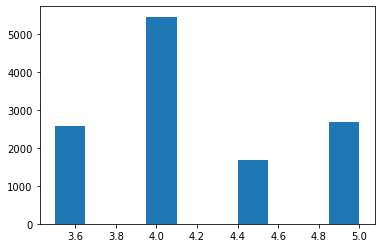

In [11]:
plt.hist(df_test_rel['rating'])
plt.show()

In [13]:
# remove train info from testing
user = 500
df_test_excl = d.df_train.loc[d.df_train.user==user]

rec = rmf.recommend(user)[0]
rec_filt = pd.DataFrame({'item': rec}, )
rec_filt = pd.merge(rec_filt, df_test_excl ,on="item", how="outer",indicator=True)
rec_filt = rec_filt.loc[rec_filt._merge=='left_only']['item']
print(len(rec), len(rec_filt))

9724 9686


9686 2


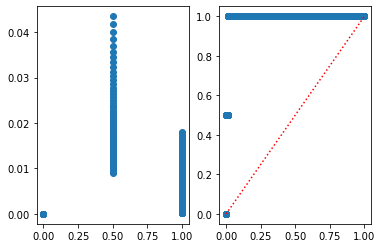

In [14]:
pos = df_test_rel[df_test_rel['user']==user]['item']

pos = set(pos)
n = len(rec_filt)
p = len(pos)

print(n, p)

f = n - p
tp = 0
fp = 0
prec = []
sens = []
fpr = []
tp_pos = []

for i, r in enumerate(rec_filt):
    if r in pos:
        tp += 1
        tp_pos.append(i)
    else:
        fp += 1
    prec.append(tp/(i+1))
    sens.append(tp/p)
    fpr.append(fp/f)

plt.subplot(121)
plt.plot(sens, prec, 'o')
plt.subplot(122)
plt.plot(fpr, sens, 'o')
plt.plot([0,1], [0,1], 'r:')
plt.show()

In [15]:
prec = np.array(prec)
sens = np.array(sens)
fpr = np.array(fpr)
dsens = sens[1:] - sens[:-1]
dfpr = fpr[1:] - fpr[:-1]
print(np.sum(prec[1:]*dsens))
print(np.sum(sens[1:]*dfpr))

0.030748139443791615
0.9932362660057827


In [18]:
compute_auc(rmf, user, df_test_rel, d.df_train)

0.9932362660057827

In [19]:
compute_ap(rmf, user, df_test_rel, d.df_train)

0.030748139443791615

In [20]:
item = 293

In [33]:
r = d.md_df.loc[d.md_df['title'].map(lambda t: t.startswith('Pulp Fiction'))]
print(r)

                        title                       genres
item_cat                                                  
257       Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller


In [34]:
item = r.index[0]
a,s = rmf.similar_to(item)

In [35]:
md = d.fetch_md(a).merge(d.stats, right_index=True, left_on='item_cat')
md[md['user'] > 50]

,title,genres,user
item_cat,,,
314,Forrest Gump (1994),Comedy|Drama|Romance|War,329
43,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,203
510,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279
461,Schindler's List (1993),Drama|War,220
31,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,177
...,...,...,...
1857,Crocodile Dundee (1986),Adventure|Comedy,57
6743,Kung Fu Panda (2008),Action|Animation|Children|Comedy|IMAX,54
6520,Superbad (2007),Comedy,55
